In [1]:
import os
import shutil
import pickle as pk
import datetime
from typing_extensions import Self
from tqdm import tqdm

import pandas as pd

import torch
import torch.optim as optim

from data import Generator, build_datasets, BatchDataLoader
from utils import load_config, save_config
from models import factory as model_factory
from train_test import Regularizer, test, comp_contrast, sparse_hess, train_epoch
from train import main as run

if torch.cuda.is_available():
    dev = 'cuda:0'
else:
    dev = 'cpu'
dev = torch.device(dev)

torch.manual_seed(0)

In [ ]:
cfg = load_config('cfg.yaml')
res = run(cfg)

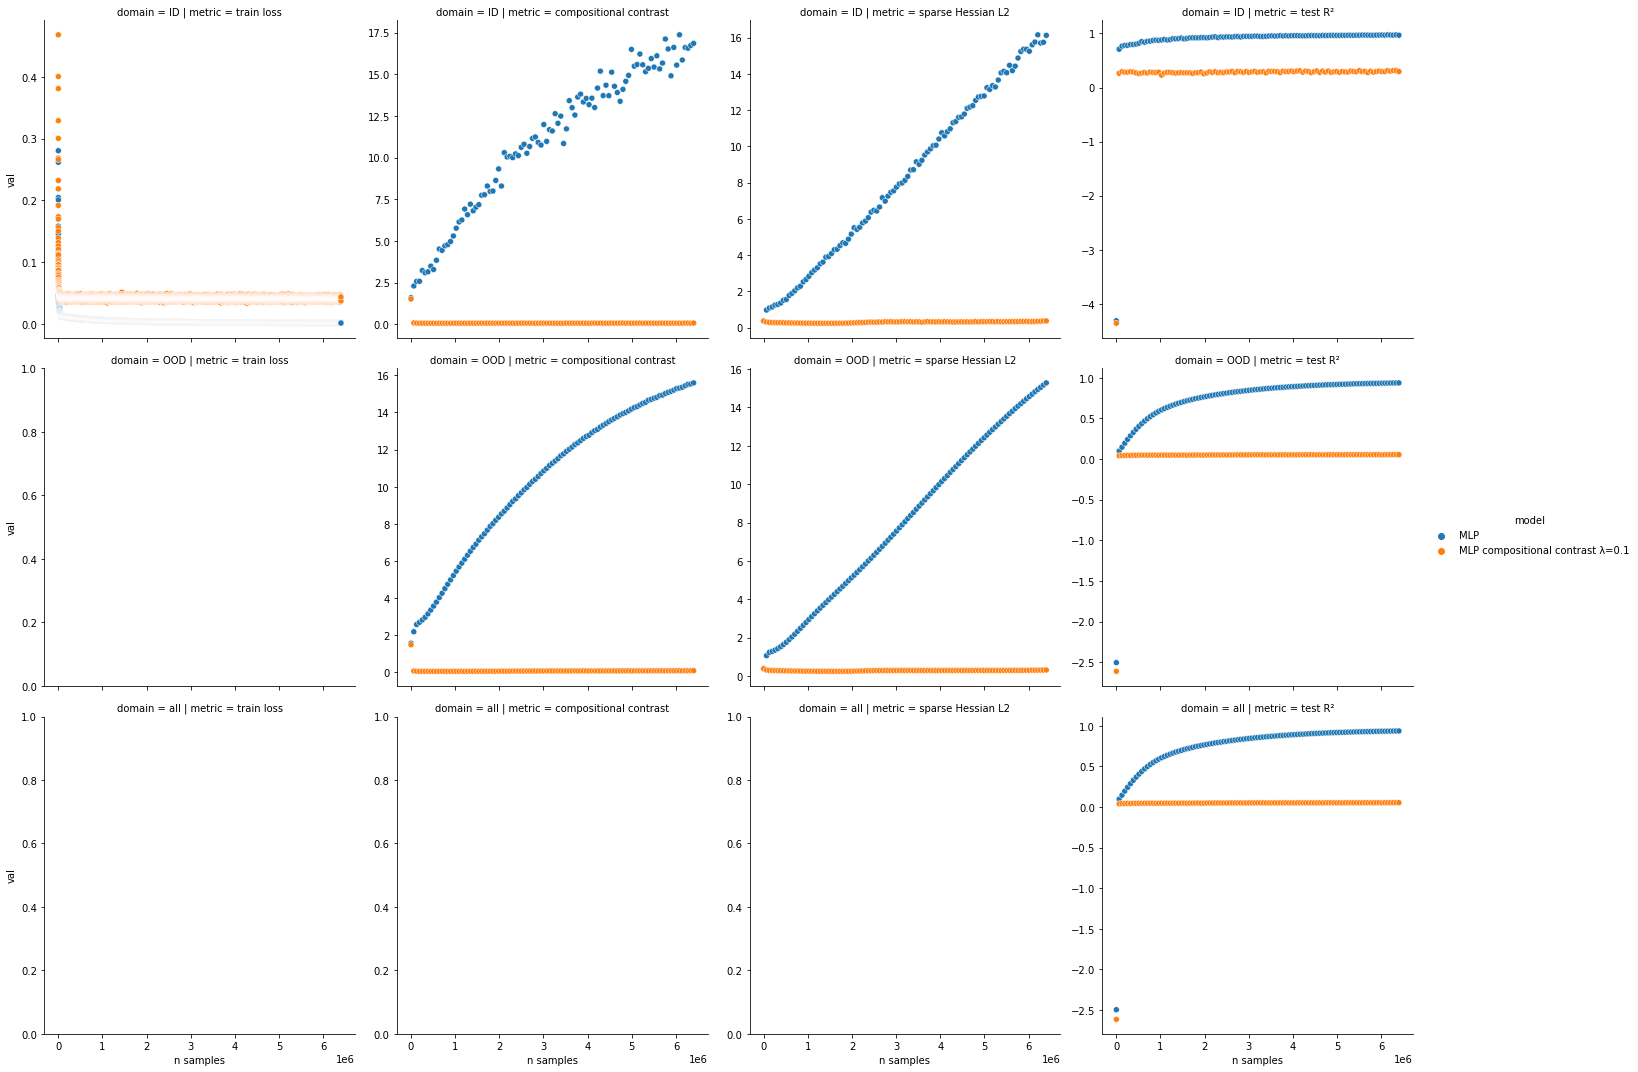

In [9]:
import seaborn as sb
fg = sb.relplot(data=res.loc[(res['n samples'] > 0)], x='n samples', y='val', hue='model', col='metric', row='domain', facet_kws={'sharey': False, 'sharex': True})

# Visualizing Training Curves

In [7]:
import pickle as pk
import seaborn as sb

with open(r'res/202209161132_testing_new_cc/df.pkl', 'rb') as f:
    df = pk.load(f)

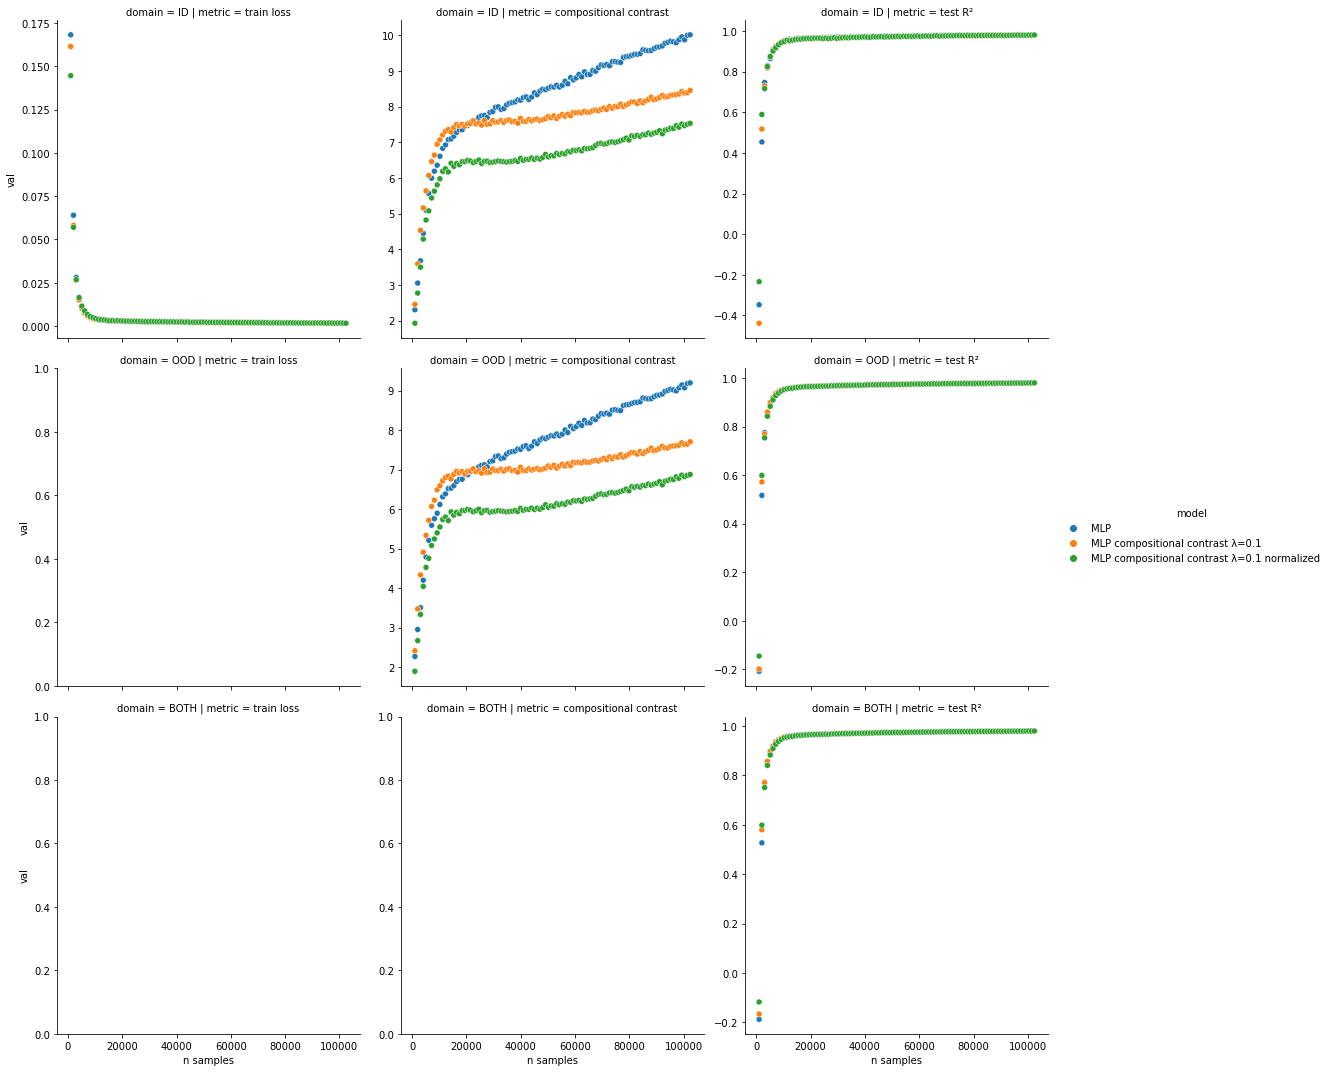

In [8]:
fg = sb.relplot(data=df.loc[(df['n samples'] > 0)], x='n samples', y='val', hue='model', col='metric', row='domain', facet_kws={'sharey': False, 'sharex': True})

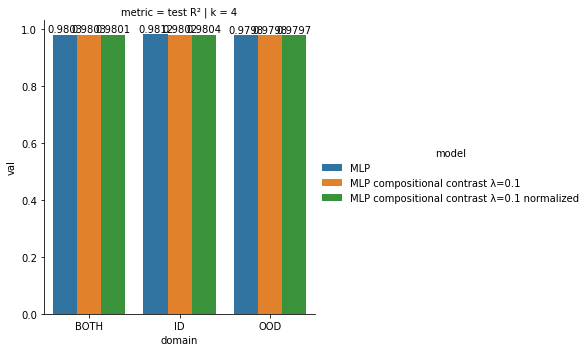

In [10]:
df_max = df.groupby(['k', 'model', 'metric', 'domain', 'n data']).max().reset_index()
fg = sb.catplot(data=df_max.loc[df_max['metric'] == 'test R²'], x='domain', y='val', hue='model', col='k', row='metric', kind='bar')
for ax in fg.axes[0]:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f')

# Visualizing Jacobians

In [9]:
k, l, m = 12, 2, 10
mlp = MLP(k, l, m).to(dev)
mlp.load_state_dict(torch.load(r'res/202209081315_gs_dim_infsampl/k12l2m10_diag02_MLP.pth'))

<All keys matched successfully>

In [4]:
data = {'str': 'diag02', 'name': 'diagonal ∆0.2', 'n': 64, 'batch_size': 64, 'generative': False, 'sample_kwargs': {'sample_mode': 'diagonal', 'delta': 0.2}, 'generator_kwargs': {}}
id_ldr, ood_ldr = build_dataloaders(k, l, m, **data)

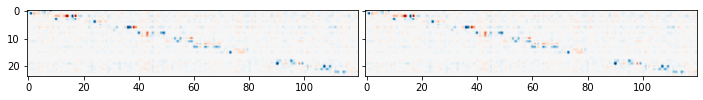

In [10]:
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(12., 24.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

iter_id = id_ldr.__iter__()
iter_ood = ood_ldr.__iter__()
for i, ax in enumerate(grid):
    if i % 2 == 0:
        x = iter_id.next()[0].flatten(1).to(dev)
        jac = functorch.vmap(functorch.jacrev(mlp))(x).mean(dim=0).detach().cpu()
    else:
        x = iter_ood.next()[0].flatten(1).to(dev)
        jac = functorch.vmap(functorch.jacrev(mlp))(x).mean(dim=0).detach().cpu()
    ax.imshow(jac, cmap='RdBu', norm=colors.TwoSlopeNorm(0))


# Validating Compositional Contrast Implementation

In [13]:
jac_mlp_id = torch.load('MLP_id')
jac_mlp_ood = torch.load('MLP_ood')
jac_mlpcc_id = torch.load('MLPCC_id')
jac_mlpcc_ood = torch.load('MLPCC_ood')

In [150]:
def my_cc(jac):
    jac = jac / jac.square().sum(-1, keepdim=True)
    # jac /= jac.square().sum(-1, keepdim=True)
    jac = torch.stack(torch.split(jac, l, dim=1), dim=1)  #  batch_size x n_slots x slot_dim x obs_dim
    jac = jac.norm(dim=2).transpose(1, 2)  #  batch_size x obs_dim x n_slots
    cc = (jac.unsqueeze(2).repeat(1, 1, jac.shape[2], 1)) * (jac.unsqueeze(2).repeat(1, 1, jac.shape[2], 1).transpose(2, 3))

    cc = 2 * cc.triu(1).sum((1, 2, 3)).mean()
    return cc

def jacks_cc_2(jac):
    bs = jac.shape[0]
    jac = jac / jac.square().sum(-1, keepdim=True)
    jac = jac.transpose(1, 2)  # batch_size x obs_dim x n_slots*slot_dim
    # all_rows = jac.reshape(jac.shape[0]*jac.shape[1], jac.shape[2])  #batch_size*obs_dim x num_slots*slot_dim
    slot_rows = torch.stack(torch.split(jac, l, dim=-1))  # num_slots x batch_size x obs_dim x slot_dim
    slot_norms = torch.norm(slot_rows, dim=-1)  # num_slots x batch_size x obs_dim
    cc = (slot_norms.sum(0).square() - slot_norms.square().sum(0)).sum(-1).mean()
    return cc

def jacks_cc(jac):
    bs = jac.shape[0]
    jac = jac / jac.square().sum(-1, keepdim=True)
    jac = jac.transpose(1, 2)
    all_rows = jac.reshape(jac.shape[0]*jac.shape[1],jac.shape[2])  #batch_size*obs_dim x num_slots*slot_dim
    slot_rows = torch.stack(torch.split(all_rows, l, dim=1))  # num_slots x batch_size*obs_dim x slot_dim
    slot_norms = torch.norm(slot_rows, dim=2)  # num_slots x batch_size*obs_dim
    cc = (slot_norms.sum(0).square() - slot_norms.square().sum(0)).sum() / bs
    return cc

# jac = torch.stack([jac_mlp_id, jac_mlpcc_id, torch.ones_like(jac_mlp_id), torch.ones_like(jac_mlp_id)])
jac = torch.stack([torch.block_diag(*torch.ones(k, l, m)), torch.ones_like(jac_mlp_id)])
# jac /= jac.square().sum(-1, keepdim=True)
print(f'{my_cc(jac):.8f}\n{jacks_cc(jac):.8f}\n{jacks_cc_2(jac):.8f}')

1.10000050
1.10000026
1.10000026


# Plotting Results as Bar Graphs

In [2]:
with open(r'res/202208111715_gs_dim_infsampl/df.pkl', 'rb') as f:
    df_k4 = pk.load(f)
with open(r'res/202209081120_gs_dim_infsampl/df.pkl', 'rb') as f:
    df_k8 = pk.load(f)
with open(r'res/202209081315_gs_dim_infsampl/df.pkl', 'rb') as f:
    df_k12 = pk.load(f)

In [8]:
df = pd.merge(df_k4, df_k8, 'outer')
df = pd.merge(df, df_k12, 'outer')

In [17]:
df_max = df.groupby(['k', 'model', 'metric', 'domain', 'n data']).max().reset_index()

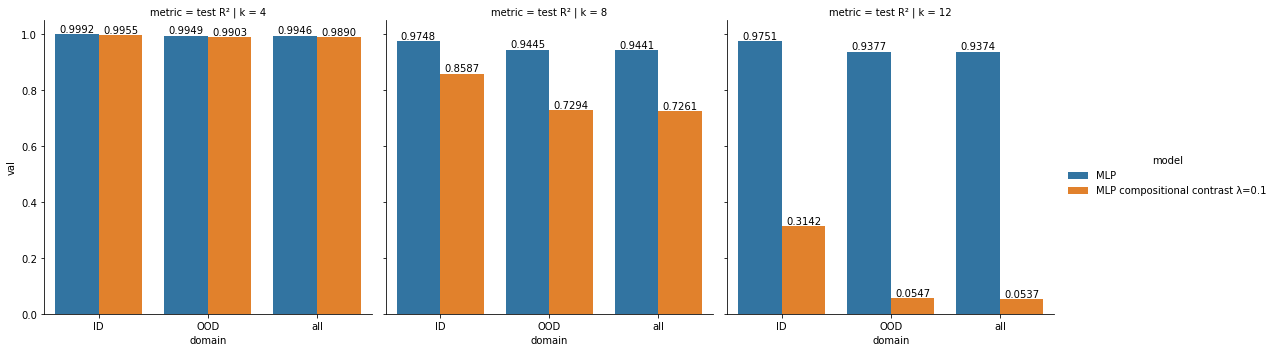

In [42]:
import seaborn as sb

fg = sb.catplot(data=df_max.loc[df_max['metric'] == 'test R²'], x='domain', y='val', hue='model', col='k', row='metric', kind='bar')
for ax in fg.axes[0]:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f')
# [_fg.set_xlabel('n batches (size 4)') for _fg in fg.axes.ravel()]
# [_fg.set_ylabel('R² score') for _fg in fg.axes.ravel()]